# Scooter Ride Share Company

---
# Introduction

A potential company, XXXXXXXX, is going to become the latest Scooter Ride Share service — the “Uber for Scooters”. We have built a basic landing page to collect and measure interest in the product, and have data about potential riders who sign up: whether they signed up or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat visitors and the number of pages visited during that session (as a proxy for site activity/time spent on site).

This project is to understand the potential rider base, and build a model that predicts conversion rate, and based on the model, come up with ideas to best go after the opportunity in the new Scooter Ride Share market.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

---
# Import the data

The rider hit data is available for download in this repsitory at [data/conversion_data.csv](data/conversion_data.csv):

The table has information about visitors during one session. Each row is a visitor session.

### Columns

 - **country** : user country based on the IP address
 - **age** : user age. Self-reported at sign-up step
 - **new_user** : whether the user created the account during this session or had already an account and simply came back to the site
 - **source** : marketing channel source
   Ads: came to the site by clicking on an advertisement
   Seo: came to the site by clicking on search results
   Direct: came to the site by directly typing the URL on the browser 
 - **total_pages_visited**: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
 - **converted**: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions. 

In [2]:
data = pd.read_csv('data/conversion_data.csv')
print('shape: ', data.shape)
data.head()

shape:  (316200, 6)


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


---
# PART I - Exploratory Data Analysis

### 1) Country

In [3]:
data['country'].unique()

array(['UK', 'US', 'China', 'Germany'], dtype=object)

The users come from 4 different countries.

### 2) Age

In [4]:
np.sort(list(data['age'].unique()))

array([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  72,  73,  77,  79, 111, 123], dtype=int64)

Here it shows that some user are 111 or 123 years old. It seems to be an error due to the acquisition of the data. Moreover, it seems interesting to see that we have users older than 60 years old for a Scooter Ride Share Service.

Number of users older than 60:  237


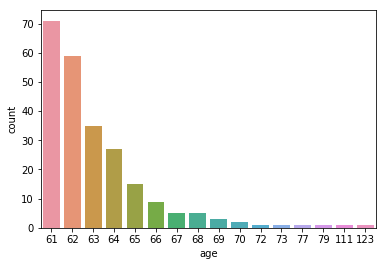

In [5]:
print('Number of users older than 60: ', data.loc[data['age']>60,'age'].shape[0])
sns.countplot(data.loc[data['age']>60,'age']);

Let's see how many of these users decided to use the service:

In [6]:
np.sort(data.loc[(data['age']>60) & (data['converted'] == 1),'age'].values)

array([ 61, 111, 123], dtype=int64)

In [7]:
print('Number of converted users older than 60: ', data.loc[(data['age']>60) & (data['converted'] == 1),'age'].shape[0])
print('Age of these users: ', np.sort(data.loc[(data['age']>60) & (data['converted'] == 1),'age'].values))

Number of converted users older than 60:  3
Age of these users:  [ 61 111 123]


It makes more sense: the users that use the website finally decide not to use the service. However, we will delete in the second part the points corresponding to the users 111 and 123 years old.

### 3) New User

In [8]:
data['new_user'].unique()

array([1, 0], dtype=int64)

It seems coherent: If the user is new, the value is 1. Otherwise, the value is 0.

### 4) Source

In [9]:
data['source'].unique()

array(['Ads', 'Seo', 'Direct'], dtype=object)

As mentionned in the README file, the 3 possible sources are advertisement, search results, or URL.

### 5) total pages visited

In [10]:
data['total_pages_visited'].unique()

array([ 1,  5,  4,  6,  2,  8,  7,  3,  9, 14, 10, 11, 18, 15, 19, 12, 13,
       21, 17, 23, 16, 25, 26, 20, 22, 24, 27, 28, 29], dtype=int64)

The total number of pages visited by a user during the session varies from 1 to 29

### 6) Converted

In [11]:
data['converted'].unique()

array([0, 1], dtype=int64)

It is coherent, this column only contains 0 or 1: 0 means the user left the session without buying anything while 1 means the user accepted a trip.

### Conclusion

From this analysis, we have a better understanding of the data. The data don't contain any NaN or unexpected value. Let's now prepare the data in order to build our prediction model.

---
# PART II - Data Cleaning and One Hot Encoding

For many of the data (Country and Source columns), we want to have integer values instead of string values. In fact, these columns contain categorical data, not numerical, so we cannot use them as-is for regression.

A first method would be to affect each of the unique values to an integer through the mean of a dictionnary and replace in the DataFrame the string by these integers.

For instance, we could create the following dictionnary for the countries:
dico_country = {
    'UK': 1,
    'US': 2,
    'China': 3,
    'Germany': 4
}

However, by using this method, we create a different weight for each value of the unique values.


Fortunately, we will perform a one-hot encoding transformation on these categorical variables to convert them into numerical variables. The transformation works as follows: create a new column for every unique value in a categorical variable. The column contains a 1 if the variable originally had the corresponding value, otherwise the column contains a 0.

### 1) Age

But first, we noticed during the Exploratory Data Analysis that some customers are 111 or 123 years old. This seems to be an error. In order to have a better accuracy when building our prediction model, we will not take these rows into consideration.

In [12]:
data = data.loc[ (data['age'] != 111) & (data['age'] != 123) , : ]
print('shape: ', data.shape)
data.head()

shape:  (316198, 6)


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


We only have 2 row less than the beginning.

### 2) One Hot Encoding

In [13]:
all_columns = data.columns
all_columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

To perform one-hot encoding we can use scikit-learn's DictVectorizer class. To use the class, we have to convert our dataframe into a list of dictionaries. The DictVectorizer class automatically one-hot encodes the categorical data (which needs to be strings) and leaves numerical data untouched.

In [14]:
records = data[all_columns].to_dict(orient = 'records')
encoder = DictVectorizer(sparse = False)
encoded_X = encoder.fit_transform(records)
encoded_X

array([[25.,  0.,  0., ...,  0.,  0.,  1.],
       [23.,  0.,  0., ...,  0.,  1.,  5.],
       [28.,  0.,  0., ...,  0.,  1.,  4.],
       ...,
       [25.,  0.,  1., ...,  0.,  0.,  4.],
       [22.,  0.,  0., ...,  0.,  1.,  4.],
       [24.,  0.,  0., ...,  0.,  0.,  4.]])

To get a better sense of the transformed data, we can display it with the column names:

In [15]:
data = pd.DataFrame(data = encoded_X, columns = encoder.feature_names_)
print('Shape of the encoded dataset: ', data.shape)
data.head()

Shape of the encoded dataset:  (316198, 11)


,age,converted,country=China,country=Germany,country=UK,country=US,new_user,source=Ads,source=Direct,source=Seo,total_pages_visited
0,25.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,23.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,5.0
2,28.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,4.0
3,39.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5.0
4,30.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,6.0


We now have 11 features, and this will make our prediction model more accurrate.

### Conclusion

We don't need to change anything for the 'new_user', the 'total_pages_visited', and the 'converted' columns since these three features only have integers. Let's now build the prediction model.

---
# PART III - Train-Test Split

### 1) Training Validation Split

The data we have is all the data we have available for both training the model and validating the model that we train. We therefore need to split the data into separate training and validation datasets. We will need this validation data to assess the performance of our classifier once we are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every runs.

In [16]:
train, test = train_test_split(data, test_size = 0.1, random_state = 42)
print('train shape: ', train.shape)
print('val shape: ', test.shape)

train shape:  (284578, 11)
val shape:  (31620, 11)


### 2) Retrieve X_train and Y_train

We divide our training dataset into a features matrix and a real values (converted or not converted) vector

In [17]:
features = data.columns.drop(['converted'])
features

Index(['age', 'country=China', 'country=Germany', 'country=UK', 'country=US',
       'new_user', 'source=Ads', 'source=Direct', 'source=Seo',
       'total_pages_visited'],
      dtype='object')

In [18]:
scaler = StandardScaler()

# Features matrix
X_train = train[features]

# We normalize the matrix
scaler.fit(X_train)
X_train = scaler.transform(X_train)

# Real Values vector
Y_train = train['converted']

Normalizing the features helps us to have a better accuracy when building our model. Each feature will contain values between 0 and 1. This will also permit us to interpret the importance of each feature after building the prediction model.

### 3) Baseline Model

We check the class distribution to build the baseline model. This model will predict only 0 or only 1 (depending on the maximum number of values of these two classes).

The accuracy of this very basic model is the one that we will try to beat by building more complex algorithms.

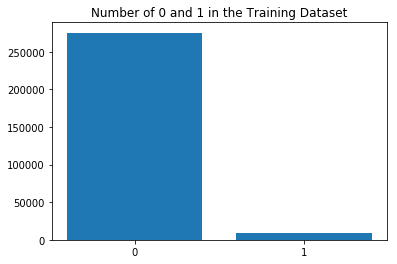

In [19]:
plt.bar(['0', '1'], Y_train.value_counts())
plt.title('Number of 0 and 1 in the Training Dataset');

Here, the baseline model will predict only 0. Therefore, the accuracy will be:

In [20]:
print('The accuracy of the baseline model on the training dataset is: ', Y_train.value_counts()[0]/len(Y_train))

The accuracy of the baseline model on the training dataset is:  0.9676749432493025


### 4) X_test and Y_test

The test dataset is used to assess the performance of our classifier once we are finished training. We divide our test dataset into a features matrix and a vector of the values that we want to predict.

In [21]:
# Features matrix
X_test = test[features]

# We normalize the matrix
X_test = scaler.transform(X_test)

# Real Values vector
Y_test = test['converted'] 

Here, the baseline model will predict only 0. Therefore, the accuracy will be:

In [22]:
print('The accuracy of the baseline model on the test dataset is: ', Y_test.value_counts()[0]/len(Y_test))

The accuracy of the baseline model on the test dataset is:  0.9684060721062618


---

# PART VI - Evaluating Classifiers

First, we are evaluating accuracy on the training set, which may lead to a misleading accuracy measure, especially if we used the training set to identify discriminative features. 

Presumably, our classifier will be used for filtering. There are two kinds of errors we can make:
- False positive (FP): A user that will not buy the service and that will be considered as converted.
- False negative (FN): A user that will be buy the service and that won't be considered as converted.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of predicted conversions that are actually conversions.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of conversions that were correctly flagged as conversions. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of non-conversions that were incorrectly flagged as conversions. 

The following image summarizes these errors:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a user that will buy the service and will be considered as converted, and a true negative (TN) is a user that won't buy anything and that won't be considered as converted.

In [23]:
# We add the results in the Test and Training data Frame
Test = pd.DataFrame(columns = ['Model', 'Accuracy', 'Test_Precision', 'Test_Recall', 'Test_FAR'])
Training = pd.DataFrame(columns = ['Model', 'Accuracy', 'Training_Precision', 'Training_Recall', 'Training_FAR'])

def evaluate_classifier(model, train_or_test, name):
     
    global Test
    global Training
    
    if train_or_test == 'train':
        
        predictions = model.predict(X_train)
        
        TP = sum((predictions == Y_train) & (predictions == 1))
        TN = sum((predictions == Y_train) & (predictions == 0))
        FP = sum((predictions != Y_train) & (predictions == 1))
        FN = sum((predictions != Y_train) & (predictions == 0))
    
        precision = TP / (TP + FP) 
        recall = TP / (TP + FN) 
        false_alarm_rate = FP / (FP + TN)
        accuracy = (TP + TN)/len(Y_train)
        
        Training = Training.append({'Model': name,
                                    'Accuracy' : accuracy,
                                    'Training_Precision' : precision, 
                                    'Training_Recall' : recall, 
                                    'Training_FAR' : false_alarm_rate}
                           , ignore_index=True)
        
        print('Accuracy score on the training dataset:', accuracy)
        print('\nThe training precision is: ', precision)
        print('\nThe training recall is: ', recall)
        print('\nThe training False Alarm Rate is: ', false_alarm_rate)
        
    else:
        
        predictions = model.predict(X_test)
        
        TP = sum((predictions == Y_test) & (predictions == 1))
        TN = sum((predictions == Y_test) & (predictions == 0))
        FP = sum((predictions != Y_test) & (predictions == 1))
        FN = sum((predictions != Y_test) & (predictions == 0))
        
        precision = TP / (TP + FP) 
        recall = TP / (TP + FN) 
        false_alarm_rate = FP / (FP + TN)
        accuracy = (TP + TN)/len(Y_test)
        
        Test = Test.append({'Model': name,
                            'Accuracy' : accuracy,
                            'Test_Precision' : precision, 
                            'Test_Recall' : recall, 
                            'Test_FAR' : false_alarm_rate}
                           , ignore_index=True)
        
        print('Accuracy score on the test dataset:', accuracy)
        print('\nThe test precision is: ', precision)
        print('\nThe test recall is: ', recall)
        print('\nThe test False Alarm Rate is: ', false_alarm_rate)

---
# PART VII - Different Models

---
## First Model: Decision Tree

While the Decision Tree model is usually not the best model to have a good precision, it is in general good to run it to have a first insight of the data before building a more complex model.

This model is often subject to a high variance due to overfitting: if we change the training set, the tree built will be different.

In [24]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [25]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, Y_train)

In [26]:
evaluate_classifier(dtree, 'train', name = 'Decision Tree')
print('\n')
evaluate_classifier(dtree, 'test', name = 'Decision Tree')

Accuracy score on the training dataset: 0.9880208589560683

The training precision is:  0.9064869418702611

The training recall is:  0.7018154147189912

The training False Alarm Rate is:  0.0024184850696676217


Accuracy score on the test dataset: 0.9856103731815307

The test precision is:  0.8487179487179487

The test recall is:  0.6626626626626627

The test False Alarm Rate is:  0.0038535645472061657


---
## Random Forest Algorithm

This model is in general one the most accurate one that we can build. As a matter of fact, Random Forest Algorithm has multiple random decision trees. Therefore, the noisy information will be cancelled out by the sampling. Although some trees in the forest can overfit, the model has a lower variance while maintaining the same low bias than a decision tree.

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
random_forest = RandomForestClassifier(n_estimators=150, random_state=0)
random_forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [29]:
evaluate_classifier(random_forest, 'train', name = 'Random Forest Algorithm')
print('\n')
evaluate_classifier(random_forest, 'test', name = 'Random Forest Algorithm')

Accuracy score on the training dataset: 0.9880208589560683

The training precision is:  0.8879656928437416

The training recall is:  0.7202956843135123

The training False Alarm Rate is:  0.003035816093456654


Accuracy score on the test dataset: 0.9857685009487666

The test precision is:  0.8393077873918418

The test recall is:  0.6796796796796797

The test False Alarm Rate is:  0.00424545246726103


---
## Gradient Boosting

This model is often used for anomalies detection (very imbalanced dataset): cancer, fraud...

It has a lot of flexibility that often provide a predictive accuracy that cannot be beat. However, if the data is noisy, the model is very sensitive to overfitting and will have a high variance.

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [32]:
evaluate_classifier(gradient_boosting, 'train', name = 'Gradient Boosting')
print('\n')
evaluate_classifier(gradient_boosting, 'test', name = 'Gradient Boosting')

Accuracy score on the training dataset: 0.9860916866377584

The training precision is:  0.8535960059371205

The training recall is:  0.6876834438525927

The training False Alarm Rate is:  0.003940024475359414


Accuracy score on the test dataset: 0.9869070208728653

The test precision is:  0.8633540372670807

The test recall is:  0.6956956956956957

The test False Alarm Rate is:  0.003592305933836256


---
## Logistic Regression

The Logistic Regression model can give the user probabilities. This is a huge advantage. However, this model is very sensitive to correlated features: the variance of the model can be very high.

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, Y_train)

C:\Users\Elias\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [35]:
evaluate_classifier(logistic_regression, 'train', name = 'Logistic Regression')
print('\n')
evaluate_classifier(logistic_regression, 'test', name = 'Logistic Regression')

Accuracy score on the training dataset: 0.9860881726626795

The training precision is:  0.8543413578577225

The training recall is:  0.6867050766387651

The training False Alarm Rate is:  0.0039109736036516945


Accuracy score on the test dataset: 0.987033523086654

The test precision is:  0.867665418227216

The test recall is:  0.6956956956956957

The test False Alarm Rate is:  0.0034616766271513013


--- 
## Support Vector Machine

This model usually works very well when we have a lot of features. However, it is difficult to interpret the final model.

In [36]:
from sklearn import svm

In [37]:
svm = svm.SVC()
svm.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [38]:
evaluate_classifier(svm, 'train', name = 'Support Vector Machine')
print('\n')
evaluate_classifier(svm, 'test', name = 'Support Vector Machine')

Accuracy score on the training dataset: 0.9858000267062106

The training precision is:  0.8899304505594194

The training recall is:  0.6398521578432438

The training False Alarm Rate is:  0.002643629325402445


Accuracy score on the test dataset: 0.9862428842504743

The test precision is:  0.8852459016393442

The test recall is:  0.6486486486486487

The test False Alarm Rate is:  0.00274321544038405


---
## Adaboost Classifier

This model is similar to the Gradient Boosting Model but add weight on the different decision trees. It is in general as performing as SVM and can achieve similar results with much less tweaking parameters or settings. However, it is really sensitive to noisy data and outliers.

In [39]:
from sklearn.ensemble import AdaBoostClassifier

In [40]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [41]:
evaluate_classifier(adaboost, 'train', name = 'Adaboost Classifier')
print('\n')
evaluate_classifier(adaboost, 'test', name = 'Adaboost Classifier')

Accuracy score on the training dataset: 0.9857367751547906

The training precision is:  0.8549723756906077

The training recall is:  0.6728992281769758

The training False Alarm Rate is:  0.0038129269116381425


Accuracy score on the test dataset: 0.9865275142314991

The test precision is:  0.8631178707224335

The test recall is:  0.6816816816816816

The test False Alarm Rate is:  0.003526991280493779


---
# PART VIII - Conclusions

Here are the results that we get for the training and test datasets. We will choose our model according to the best metric on the test datasets.

Some notes:
- Decision Tree: While it has one of the best precision on the training dataset, the Decision Tree model has one of the lowest precision on the test dataset. It seems understandable since this model is the one with the highest variance.

- For all of the four last models, we can notice that their accuracy is almost the same (~ 0.98). We also can see that they have a very low variance since the precision on the training and validation datasets are really close.

**According to first the precision, and then to the accuracy, the best model is the Support Vector Machine. It has an accuracy of 98.62%, and the best precision (88.52%) on the test dataset.**

Finally, we also can notice that this model has a higher accuracy than the baseline model (96.77%).

In [42]:
Training

,Model,Accuracy,Training_Precision,Training_Recall,Training_FAR
0,Decision Tree,0.988021,0.906487,0.701815,0.002418
1,Random Forest Algorithm,0.988021,0.887966,0.720296,0.003036
2,Gradient Boosting,0.986092,0.853596,0.687683,0.003940
3,Logistic Regression,0.986088,0.854341,0.686705,0.003911
4,Support Vector Machine,0.985800,0.889930,0.639852,0.002644
5,Adaboost Classifier,0.985737,0.854972,0.672899,0.003813


In [43]:
Test

,Model,Accuracy,Test_Precision,Test_Recall,Test_FAR
0,Decision Tree,0.985610,0.848718,0.662663,0.003854
1,Random Forest Algorithm,0.985769,0.839308,0.679680,0.004245
2,Gradient Boosting,0.986907,0.863354,0.695696,0.003592
3,Logistic Regression,0.987034,0.867665,0.695696,0.003462
4,Support Vector Machine,0.986243,0.885246,0.648649,0.002743
5,Adaboost Classifier,0.986528,0.863118,0.681682,0.003527


### Recommandations and Improvements

In order to improve the model, it could be useful to have more features such as:
   - The gender of the user
   - The price of the service
   - The total duration of the ride
   
These features could improve the precision of the classifier.